# Importing the libraries

In [1]:
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sqlalchemy import create_engine
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from gensim.models import Word2Vec 
import joblib

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Loading the data

In [50]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df = pd.read_sql_table('disasters_df', engine)

# Data Exploration

In [51]:
# Data length
df.shape[0]

26216

In [52]:
df.isna().sum()

id                            0
message                       0
original                  16046
genre                         0
related                       0
request                       0
offer                         0
aid_related                   0
medical_help                  0
medical_products              0
search_and_rescue             0
security                      0
military                      0
child_alone                   0
water                         0
food                          0
shelter                       0
clothing                      0
money                         0
missing_people                0
refugees                      0
death                         0
other_aid                     0
infrastructure_related        0
transport                     0
buildings                     0
electricity                   0
tools                         0
hospitals                     0
shops                         0
aid_centers                   0
other_in

There is only one column that has NA value, the original column. Let's take a look.

In [53]:
df[df['original'].isna()]

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
7423,8365,NOTES: It mark as not enough information,None,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9891,11186,My thoughts and prayers go out to all the live...,None,social,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
9892,11188,I m sorry for the poor people in Haiti tonight...,None,social,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
9893,11189,RT selenagomez UNICEF has just announced an em...,None,social,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
9894,11192,lilithia yes 5.2 magnitude earthquake hit mani...,None,social,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26211,30261,The training demonstrated how to enhance micro...,None,news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26212,30262,A suitable candidate has been selected and OCH...,None,news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26213,30263,"Proshika, operating in Cox's Bazar municipalit...",None,news,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26214,30264,"Some 2,000 women protesting against the conduc...",None,news,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


It's seems like, when the message is already in english the original value is None.

## Getting the number of observations per label

In [54]:
cols_df = pd.DataFrame(columns=['col', 'num_obs'])
for col in df.iloc[:, 4:].columns:
  cols_df = cols_df.append({'col': col, 'num_obs': df[df[col] == 1].shape[0]}, ignore_index=True)

cols_df = cols_df.sort_values(['num_obs'])
print(cols_df.head())

            col num_obs
9   child_alone       0
2         offer     118
25        shops     120
23        tools     159
31         fire     282


In [55]:
cols_df['col'].values

array(['child_alone', 'offer', 'shops', 'tools', 'fire', 'hospitals',
       'missing_people', 'aid_centers', 'clothing', 'security', 'cold',
       'electricity', 'money', 'search_and_rescue', 'military',
       'refugees', 'other_infrastructure', 'death', 'transport',
       'medical_products', 'buildings', 'other_weather', 'water',
       'infrastructure_related', 'medical_help', 'floods', 'shelter',
       'storm', 'earthquake', 'food', 'other_aid', 'request',
       'direct_report', 'weather_related', 'aid_related', 'related'],
      dtype=object)

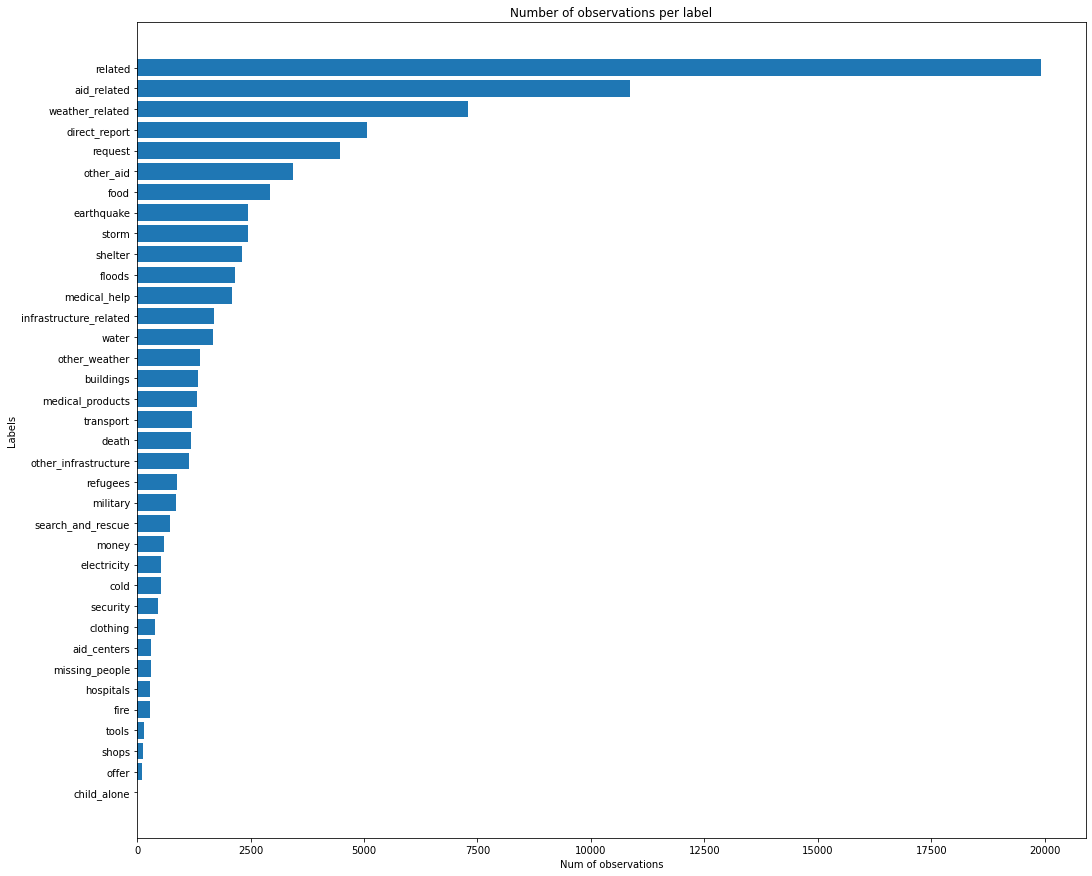

In [56]:
fig, ax = plt.subplots(figsize=(17, 15))
ax.barh(cols_df['col'].values, cols_df['num_obs'].values)
plt.title("Number of observations per label")
plt.xlabel("Num of observations")
plt.ylabel("Labels")
plt.show();

The child_alone label has 0 observations, so I gonna drop it


In [58]:
df.drop('child_alone', inplace=True, axis=1)

# Spliting the data in train and test

In [62]:
X = df.message.values
Y = df.iloc[:, 4:].values

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

# Modeling

In [75]:
def tokenize(text):
    """Tokenize the text

    Parameters
    ----------
    text: String
        The message to be tokenized

    Returns
    -------
    List
        List with the clean tokens
    """
    text = text.lower()
    text = re.sub("[^a-zA-Z0-9]", " ", text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words('english')]

    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    
    clean_tokens_list = []
    for tok in tokens:
        lemmatizer_tok = lemmatizer.lemmatize(tok).strip()
        clean_tok = stemmer.stem(lemmatizer_tok)
        clean_tokens_list.append(clean_tok)
    
    return clean_tokens_list

## Pipeline with CountVectorizer, TfidfTransformer and RandomForest

In [77]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

In [78]:
# Fitting the data
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [79]:
# Getting the predictions
y_pred = pipeline.predict(X_test)

In [80]:
def append_metrics_df(metrics_df, metrics, trial, target_metric='weighted avg'):
  for column in metrics:
    row = {'trial': trial,
          'target': column}
    for metric in metrics[column][target_metric]:
      row[metric] = metrics[column][target_metric][metric]
    metrics_df = metrics_df.append(row, ignore_index=True)
  return metrics_df

### Getting the Metrics for each label

In [108]:
metrics_random_forest = {}
for i, col in enumerate(list(df.iloc[:, 4:].columns)):
    metrics_random_forest[col] = classification_report(y_test[:, i], y_pred[:, i], output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Putting the results at a dataframe to make it possible to compare models

In [109]:
metrics_df = pd.DataFrame(columns=['trial', 'target', 'f1-score', 'precision', 'recall'])
metrics_df = append_metrics_df(metrics_df, metrics_random_forest, 'RandomForest')

## Pipeline with CountVectorizer, TfidTransformer and XGBClassifier

In [82]:
pipeline2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(XGBClassifier()))
])

In [83]:
pipeline2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                               booster='gbtree',
                                                               colsample_bylevel=1,
                                                               colsample_bynode=1,
                                                               colsample_bytree=1,
    

In [84]:
y_pred2 = pipeline2.predict(X_test)

In [110]:
metrics = {}
for i, col in enumerate(list(df.iloc[:, 4:].columns)):
    metrics[col] = classification_report(y_test[:, i], y_pred2[:, i], output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
metrics_df = append_metrics_df(metrics_df, metrics, 'xgboost')

## Custom Estimators and Transformers

In [87]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            if len(pos_tags) > 0:
              first_word, first_tag = pos_tags[0]
              if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                  return True
            else:
              continue
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [154]:
class CountPosTagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, tag_to_sum='verb'):
      if tag_to_sum == 'verb':
        self._tag_to_sum = 'VB'
      elif tag_to_sum == 'adjective':
        self._tag_to_sum = 'JJ'
      elif tag_to_sum == 'pronoun':
        self._tag_to_sum = 'PRP'
      elif tag_to_sum == 'noun':
        self._tag_to_sum = 'NN'
      else:
        self._tag_to_sum = 'VB'        

    def sum_types(self, text):
        sentence = word_tokenize(text)
        tags_list = pos_tag(sentence)
        tags_total = 0
        for tag in tags_list:
          if self._tag_to_sum in tag[1]:
            tags_total += 1
        return tags_total


    def fit(self, x, y=None):
        return self

    def transform(self, X):
        total_tags = pd.Series(X).apply(self.sum_types)
        return pd.DataFrame(total_tags)

## Pipeline with CuntVectorizer, TfidfTransformer, StartingVerbExtractor, CountPosTagTransformer for verb, noun, adjective and pronoun and XGBClassifier

In [155]:
pipeline3 = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor()),
            ('num_verbs', CountPosTagTransformer('verb')),
            ('num_nouns', CountPosTagTransformer('noun')),
            ('num_adjectives', CountPosTagTransformer('adjective')),
            ('num_pronouns', CountPosTagTransformer('pronoun'))
        ])),

        ('clf', MultiOutputClassifier(XGBClassifier()))
    ])

In [90]:
pipeline3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  low

In [91]:
y_predict3 = pipeline3.predict(X_test)

In [112]:
metrics = {}
for i, col in enumerate(list(df.iloc[:, 4:].columns)):
    metrics[col] = classification_report(y_test[:, i], y_predict3[:, i], output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
metrics_df = append_metrics_df(metrics_df, metrics, 'XGBoost_More_Features')

## Grid Search

In [127]:
pipeline3.get_params()

{'clf': MultiOutputClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                               colsample_bylevel=1,
                                               colsample_bynode=1,
                                               colsample_bytree=1, gamma=0,
                                               learning_rate=0.1,
                                               max_delta_step=0, max_depth=3,
                                               min_child_weight=1, missing=None,
                                               n_estimators=100, n_jobs=1,
                                               nthread=None,
                                               objective='binary:logistic',
                                               random_state=0, reg_alpha=0,
                                               reg_lambda=1, scale_pos_weight=1,
                                               seed=None, silent=None,
                                    

In [156]:
parameters = {
    'features__text_pipeline__tfidf__use_idf': (True, False),
    'clf__estimator__learning_rate': [0.1, 0.01, 0.001],
}

cv = GridSearchCV(pipeline3, param_grid=parameters)

In [157]:
cv.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/pytho

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('text_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('vect',
                                                                                         CountVectorizer(analyzer='word',
                                                                                                         binary=False,
                                                                                                         decode_error='strict',
                                                                                                         dtype=<class 'numpy.int64'>,
               

In [158]:
y_pred_cv = cv.predict(X_test)

In [159]:
cv.best_params_

{'clf__estimator__learning_rate': 0.1,
 'features__text_pipeline__tfidf__use_idf': False}

In [160]:
metrics_cv = {}
for i, col in enumerate(list(df.iloc[:, 4:].columns)):
    metrics_cv[col] = classification_report(y_test[:, i], y_pred_cv[:, i], output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [161]:
metrics_df = append_metrics_df(metrics_df, metrics_cv, 'XGBoost_CV')

## Analysing the results 

In [162]:
# Getting the average score for each trial
metrics_df.groupby('trial').agg('sum') / Y.shape[1]

,f1-score,precision,recall,support
trial,,,,
RandomForest,0.935922,0.937984,0.947826,5244.0
XGBoost_CV,0.938327,0.941213,0.948235,5244.0
XGBoost_More_Features,0.938832,0.941320,0.948376,5244.0
xgboost,0.937866,0.941037,0.947957,5244.0


In [163]:
metrics_df = metrics_df.sort_values('f1-score')

In [2]:
metrics_df = pd.read_csv('/content/drive/MyDrive/Estudos/Data Science Nano/metrics.csv')

In [3]:
best_metrics_df = metrics_df[metrics_df['trial'] == 'XGBoost_More_Features'].sort_values(['f1-score'])
best_metrics_df.head()

,Unnamed: 0,trial,target,f1-score,precision,recall,support
2,70,XGBoost_More_Features,related,0.736104,0.784208,0.789855,5244.0
5,73,XGBoost_More_Features,aid_related,0.755182,0.761815,0.761823,5244.0
11,87,XGBoost_More_Features,other_aid,0.830268,0.842857,0.873188,5244.0
15,104,XGBoost_More_Features,direct_report,0.838979,0.851904,0.859268,5244.0
17,97,XGBoost_More_Features,weather_related,0.864858,0.874104,0.872426,5244.0


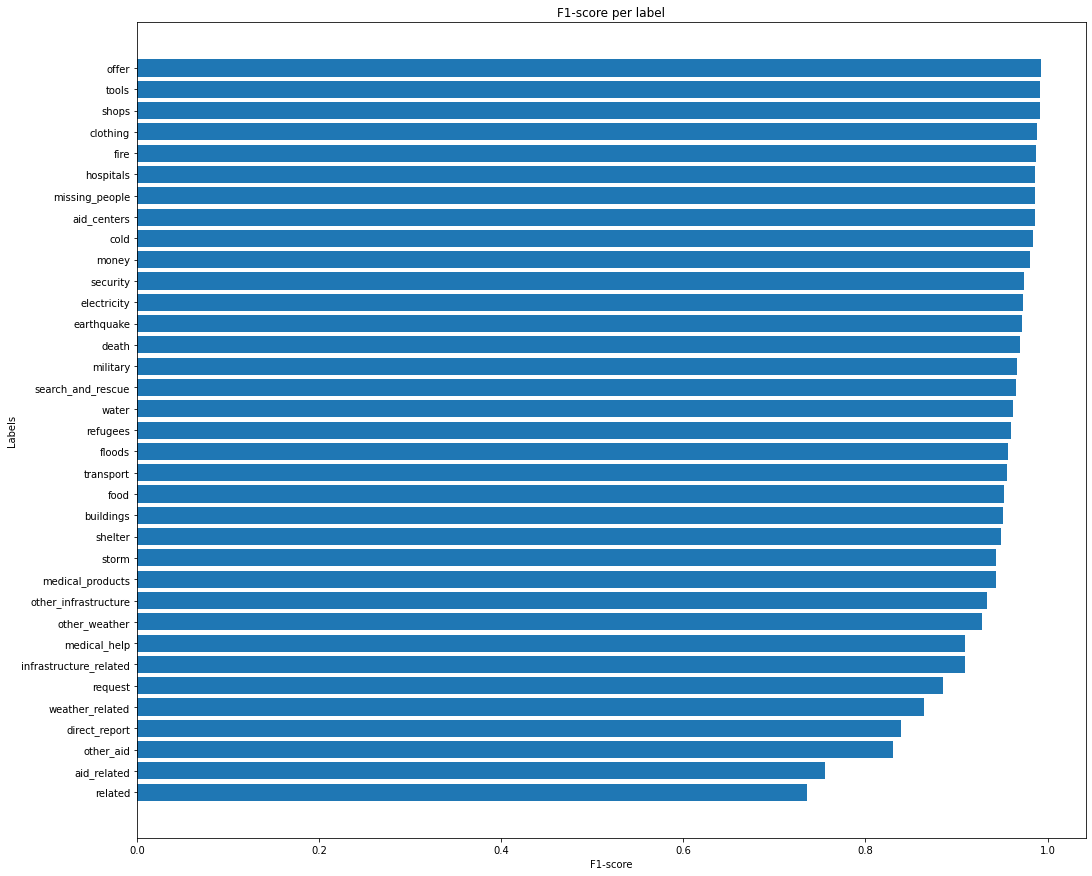

In [4]:
# Plotting the scores per label of the best trial
fig, ax = plt.subplots(figsize=(17, 15))
ax.barh(best_metrics_df['target'].values, best_metrics_df['f1-score'].values)
plt.title("F1-score per label")
plt.xlabel("F1-score")
plt.ylabel("Labels")
plt.show();

## Saving the model

In [ ]:
joblib.dump(pipeline, 'filename2.pkl')

['filename2.pkl']